# Problem Set 7

## Yanwei Pan
panyw@uchicago.edu

### Problem 1

In [123]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import statsmodels.api as sm
import scipy.interpolate as si

In [125]:
#####a#####
wine_df = pd.read_csv('data/strongdrink.txt')
wine_df.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [126]:
X = wine_df[['alco', 'malic', 'tot_phen', 'color_int']]
y = wine_df['cultivar']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, \
                                                      random_state=20)

In [127]:
LogReg = LogisticRegression(solver='newton-cg', multi_class='multinomial').fit(X_train, y_train)
ind = pd.DataFrame(['beta0', 'beta1', 'beta2', 'beta3', 'beta4'])
# LogReg.coef_[0]
j1 = pd.DataFrame([LogReg.intercept_[0]] + LogReg.coef_[0].tolist())
j2 = pd.DataFrame([LogReg.intercept_[1]] + LogReg.coef_[1].tolist())
result_df = pd.concat([ind, j1, j2], axis=1)
result_df.columns = ['coefficient','j = 1','j = 2']
result_df

,coefficient,j = 1,j = 2
0,beta0,-24.010571,22.802707
1,beta1,1.700370,-1.468065
2,beta2,-0.265602,-0.333055
3,beta3,1.223892,0.664017
4,beta4,0.022762,-0.922714


In [128]:
y_pred = LogReg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.87      1.00      0.93        13
           2       1.00      0.90      0.95        21
           3       1.00      1.00      1.00        10

    accuracy                           0.95        44
   macro avg       0.96      0.97      0.96        44
weighted avg       0.96      0.95      0.96        44



In [129]:
error_df = pd.DataFrame({'error rate': [0.13, 0, 0]})
error_df.index = ['j = 1', 'j = 2', 'j = 3']
error_df

,error rate
j = 1,0.13
j = 2,0.00
j = 3,0.00


The error rates are 13%, 0%, and 0% for j = 1, j = 2 and j = 3.  
The model that is best at predicting is j = 3 because it has the highest f1-score.  
j = 2 has the most observations, but it is not the most accurately predicted category. Thus, the one with the most observations isn't the most accurately predicted category.

In [131]:
print('MSE =', mean_squared_error(y_test, y_pred))

MSE = 0.045454545454545456


In [101]:
#####b#####
Xvars = X.values
yvars = y.values
N_loo = Xvars.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvars)
MSE_vec = np.zeros(N_loo)
y_pred = np.zeros(N_loo)

for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    LogReg = LogisticRegression(solver='newton-cg',multi_class='multinomial').fit(X_train, y_train)
    y_pred[test_index] = LogReg.predict(X_test)
    if y_test == y_pred[test_index]:
        MSE_vec[test_index] = 0
    else:
        MSE_vec[test_index] = 1

MSE_loo = MSE_vec.mean()
print('LOOCV Estimate MSE =', MSE_loo)

LOOCV Estimate MSE = 0.07954545454545454


In [102]:
print(classification_report(yvars, y_pred))

              precision    recall  f1-score   support

           1       0.90      0.93      0.92        59
           2       0.91      0.90      0.91        71
           3       0.96      0.93      0.95        46

    accuracy                           0.92       176
   macro avg       0.92      0.92      0.92       176
weighted avg       0.92      0.92      0.92       176



In [103]:
error_df = pd.DataFrame({'error rate': [0.10, 0.09, 0.04]})
error_df.index = ['j = 1', 'j = 2', 'j = 3']
error_df

,error rate
j = 1,0.10
j = 2,0.09
j = 3,0.04


The error rates are 10%, 9%, and 4% for j = 1, j = 2 and j = 3.  
The error rate increases in j = 2 and j = 3, but the error rate decreases in j = 1. Generally speaking, the error rate increases compared to those from part(a)

In [104]:
#####c#####
k = 4
kf = KFold(n_splits=4, shuffle=True, random_state=10)
kf.get_n_splits(Xvars)

MSE_vec_kf = np.zeros(k)
y_pred = np.zeros(len(yvars))

k_ind = int(0)
for train_index, test_index in kf.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    LogReg = LogisticRegression(solver='newton-cg',multi_class='multinomial').fit(X_train, y_train)
    y_pred[test_index] = LogReg.predict(X_test)
    err = y_pred[test_index] != y_test
    MSE_vec_kf[k_ind] = err.mean()
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
print('K-fold Estimate MSE =', MSE_kf)

K-fold Estimate MSE = 0.09090909090909091


In [105]:
print(classification_report(yvars, y_pred))

              precision    recall  f1-score   support

           1       0.87      0.93      0.90        59
           2       0.91      0.87      0.89        71
           3       0.96      0.93      0.95        46

    accuracy                           0.91       176
   macro avg       0.91      0.91      0.91       176
weighted avg       0.91      0.91      0.91       176



In [106]:
error_df = pd.DataFrame({'error rate': [0.13, 0.09, 0.04]})
error_df.index = ['j = 1', 'j = 2', 'j = 3']
error_df

,error rate
j = 1,0.13
j = 2,0.09
j = 3,0.04


The error rates are 13%, 9%, and 4% for j = 1, j = 2 and j = 3.  
The error rate increases in j = 2 and j = 3, but keep the same rate at j = 1 compared to those from part(a). While comparing to the part(b), the error rate increases in j = 1, but keep the same rate in j = 2 and j = 3.

### Problem 2

In [107]:
#####a#####
cool_df = pd.read_csv("data/CoolIndex.txt",names=["age","coolness_ind"])
cool_df.head()

,age,coolness_ind
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


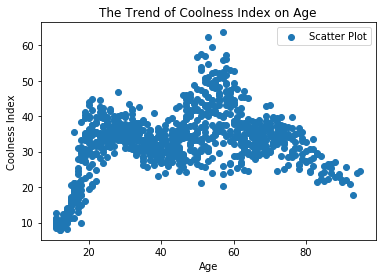

In [108]:
plt.scatter(cool_df['age'], cool_df['coolness_ind'], label='Scatter Plot')
plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.title("The Trend of Coolness Index on Age")
plt.legend()
plt.show()

In [109]:
#####b#####
cool_df['g1'] = np.where((cool_df['age'] >= 11) & (cool_df['age'] < 22), 1, 0)
cool_df['g2'] = np.where((cool_df['age'] >= 22) & (cool_df['age'] < 40), 1, 0)
cool_df['g3'] = np.where((cool_df['age'] >= 40) & (cool_df['age'] < 59), 1, 0)
cool_df['g4'] = np.where((cool_df['age'] >= 59) & (cool_df['age'] < 77), 1, 0)
cool_df['g5'] = np.where((cool_df['age'] >= 77) & (cool_df['age'] <= 95), 1, 0)

In [110]:
ols_result = sm.OLS(cool_df['coolness_ind'], \
                    cool_df[['g1', 'g2', 'g3', 'g4', 'g5']]).fit()

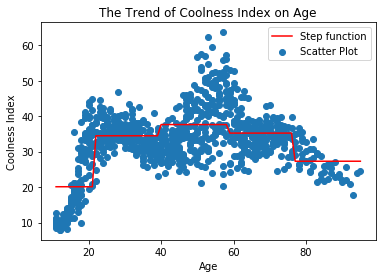

In [111]:
plt.scatter(cool_df['age'], cool_df['coolness_ind'], label='Scatter Plot')
plt.plot(cool_df['age'], ols_result.predict(), color='r', label="Step function")
plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.title("The Trend of Coolness Index on Age")
plt.legend()
plt.show()

In [112]:
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:           coolness_ind   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Tue, 25 Feb 2020   Prob (F-statistic):          3.73e-114
Time:                        21:26:05   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
g1            20.1025      0.562     35.746      0.0

The estimated step function values for each bin β1, β2, β3, β4, β5 are 20.1025, 34.4758, 37.6351, 35.2254, 27.2964

In [113]:
print('The predicted coolness of a 73-year old from the stepwise function is ', \
      ols_result.predict([0,0,0,1,0])[0])

The predicted coolness of a 73-year old from the stepwise function is  35.22540004024275


In [114]:
#####c#####
df = cool_df.groupby('age').mean()
df

,coolness_ind,g1,g2,g3,g4,g5
age,,,,,,
11.0,10.110237,1,0,0,0,0
12.0,9.365623,1,0,0,0,0
13.0,10.015882,1,0,0,0,0
14.0,11.747109,1,0,0,0,0
15.0,15.434739,1,0,0,0,0
...,...,...,...,...,...,...
91.0,23.821051,0,0,0,0,1
92.0,20.898071,0,0,0,0,1
93.0,17.756216,0,0,0,0,1


In [116]:
df['age']=df.index
knots = [22, 40, 59, 77]
linear_spl_1 = si.LSQUnivariateSpline(np.array(df['age']), np.array(df['coolness_ind']), t=knots, k=1)

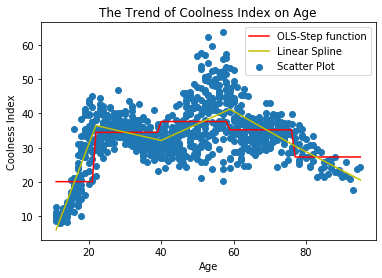

In [117]:
plt.scatter(cool_df['age'], cool_df['coolness_ind'], label='Scatter Plot')
plt.plot(cool_df['age'], ols_result.predict(), color='r', label="OLS-Step function")
plt.plot(df['age'], linear_spl_1(df['age']), color="y" , label = "Linear Spline")
plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.title("The Trend of Coolness Index on Age")
plt.legend()
plt.show()

In [118]:
print('The predicted coolness of a 73-year old from the linear spline is ', \
      linear_spl_1(73))

The predicted coolness of a 73-year old from the linear spline is  32.86784862349653


In [119]:
#####d#####
cub_spl_2 = si.LSQUnivariateSpline(np.array(df['age']), np.array(df['coolness_ind']), t=knots, k=3)

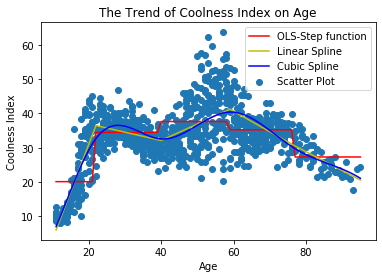

In [120]:
plt.scatter(cool_df['age'], cool_df['coolness_ind'], label='Scatter Plot')
plt.plot(cool_df['age'], ols_result.predict(), color='r', label="OLS-Step function")
plt.plot(df['age'], linear_spl_1(df['age']), color="y" , label = "Linear Spline")
plt.plot(df['age'], cub_spl_2(df['age']), color="b" , label = "Cubic Spline")
plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.title("The Trend of Coolness Index on Age")
plt.legend()
plt.show()

In [121]:
print('The predicted coolness of a 73-year old from the cubic spline is ', \
      cub_spl_2(73))

The predicted coolness of a 73-year old from the cubic spline is  32.642301066279764
